This notebook is based on Intro to DeepCell notebook. It works on tensorflow 2.7.1.<br>
It trains a model with three heads: inner distance, outer distance, and fgbg.
Trained model does not perform well on a CD3 test image.

In [1]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

import deepcell
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell import image_generators

print(tf.__version__)

2.7.1


In [2]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
     file_hash=None,
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
     file_hash=None,
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
     file_hash=None,
    metadata=None
)

In [3]:
dataset = phase  # nuclear, phase, fluo_cyto
model_name = 'phase_deep_watershed'

min_objects = 2

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 8

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

X_train.shape: (1872, 256, 256, 1)
X_test.shape: (468, 256, 256, 1)


(1872, 256, 256, 1)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


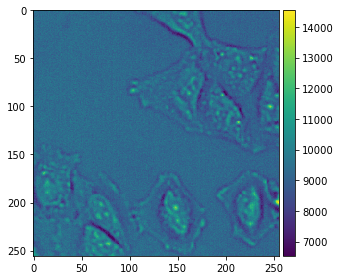

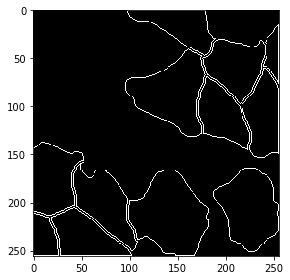

In [4]:
print(y_train.shape)

i=5

io.imshow(X_train[i,:,:,0])
plt.show()
#print(X_train[i,:,:,0])

tmp = syotil.masks_to_outlines(y_train[i,:,:,0])
io.imshow(tmp)
plt.show()

In [5]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-10-29 10:47:29.148316: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-29 10:47:30.737200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 256, 256, 1)),
 ('semantic_1', (None, 256, 256, 1)),
 ('semantic_2', (None, 256, 256, 2))]

In [6]:
# fit the model

model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

2022-10-29 10:47:35.497245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


Training on 1 GPUs.
Epoch 1/50


2022-10-29 10:47:52.218791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


234/234 [==============================] - ETA: 0s - loss: 0.1250 - semantic_0_loss: 0.0840 - semantic_1_loss: 0.0389 - semantic_2_loss: 0.0021
Epoch 00001: val_loss improved from inf to 0.14667, saving model to phase_deep_watershed.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


234/234 [==============================] - 90s 283ms/step - loss: 0.1250 - semantic_0_loss: 0.0840 - semantic_1_loss: 0.0389 - semantic_2_loss: 0.0021 - val_loss: 0.1467 - val_semantic_0_loss: 0.0045 - val_semantic_1_loss: 0.0616 - val_semantic_2_loss: 0.0806 - lr: 1.0000e-04
Epoch 2/50
234/234 [==============================] - ETA: 0s - loss: 0.0107 - semantic_0_loss: 0.0025 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0010
Epoch 00002: val_loss improved from 0.14667 to 0.07035, saving model to phase_deep_watershed.h5
234/234 [==============================] - 65s 275ms/step - loss: 0.0107 - semantic_0_loss: 0.0025 - semantic_1_loss: 0.0072 - semantic_2_loss: 0.0010 - val_loss: 0.0703 - val_semantic_0_loss: 0.0043 - val_semantic_1_loss: 0.0542 - val_semantic_2_loss: 0.0119 - lr: 9.9000e-05
Epoch 3/50
234/234 [==============================] - ETA: 0s - loss: 0.0092 - semantic_0_loss: 0.0022 - semantic_1_loss: 0.0061 - semantic_2_loss: 8.9585e-04
Epoch 00003: val_loss improved from 

234/234 [==============================] - ETA: 0s - loss: 0.0053 - semantic_0_loss: 0.0015 - semantic_1_loss: 0.0032 - semantic_2_loss: 6.5228e-04
Epoch 00017: val_loss improved from 0.00598 to 0.00593, saving model to phase_deep_watershed.h5
234/234 [==============================] - 65s 276ms/step - loss: 0.0053 - semantic_0_loss: 0.0015 - semantic_1_loss: 0.0032 - semantic_2_loss: 6.5228e-04 - val_loss: 0.0059 - val_semantic_0_loss: 0.0017 - val_semantic_1_loss: 0.0035 - val_semantic_2_loss: 7.6178e-04 - lr: 8.5146e-05
Epoch 18/50
234/234 [==============================] - ETA: 0s - loss: 0.0053 - semantic_0_loss: 0.0014 - semantic_1_loss: 0.0032 - semantic_2_loss: 6.5051e-04
Epoch 00018: val_loss improved from 0.00593 to 0.00582, saving model to phase_deep_watershed.h5
234/234 [==============================] - 64s 274ms/step - loss: 0.0053 - semantic_0_loss: 0.0014 - semantic_1_loss: 0.0032 - semantic_2_loss: 6.5051e-04 - val_loss: 0.0058 - val_semantic_0_loss: 0.0017 - val_seman

Epoch 33/50
234/234 [==============================] - ETA: 0s - loss: 0.0043 - semantic_0_loss: 0.0012 - semantic_1_loss: 0.0025 - semantic_2_loss: 5.8615e-04
Epoch 00033: val_loss did not improve from 0.00516
234/234 [==============================] - 62s 266ms/step - loss: 0.0043 - semantic_0_loss: 0.0012 - semantic_1_loss: 0.0025 - semantic_2_loss: 5.8615e-04 - val_loss: 0.0053 - val_semantic_0_loss: 0.0016 - val_semantic_1_loss: 0.0030 - val_semantic_2_loss: 6.3428e-04 - lr: 7.2498e-05
Epoch 34/50
234/234 [==============================] - ETA: 0s - loss: 0.0043 - semantic_0_loss: 0.0012 - semantic_1_loss: 0.0025 - semantic_2_loss: 5.8657e-04
Epoch 00034: val_loss did not improve from 0.00516
234/234 [==============================] - 62s 266ms/step - loss: 0.0043 - semantic_0_loss: 0.0012 - semantic_1_loss: 0.0025 - semantic_2_loss: 5.8657e-04 - val_loss: 0.0055 - val_semantic_0_loss: 0.0016 - val_semantic_1_loss: 0.0032 - val_semantic_2_loss: 7.2122e-04 - lr: 7.1773e-05
Epoch 35

234/234 [==============================] - ETA: 0s - loss: 0.0037 - semantic_0_loss: 9.8338e-04 - semantic_1_loss: 0.0022 - semantic_2_loss: 5.5202e-04
Epoch 00049: val_loss improved from 0.00481 to 0.00474, saving model to phase_deep_watershed.h5
234/234 [==============================] - 65s 278ms/step - loss: 0.0037 - semantic_0_loss: 9.8338e-04 - semantic_1_loss: 0.0022 - semantic_2_loss: 5.5202e-04 - val_loss: 0.0047 - val_semantic_0_loss: 0.0015 - val_semantic_1_loss: 0.0027 - val_semantic_2_loss: 5.7981e-04 - lr: 6.1729e-05
Epoch 50/50
234/234 [==============================] - ETA: 0s - loss: 0.0037 - semantic_0_loss: 9.9786e-04 - semantic_1_loss: 0.0022 - semantic_2_loss: 5.5311e-04
Epoch 00050: val_loss did not improve from 0.00474
234/234 [==============================] - 64s 271ms/step - loss: 0.0037 - semantic_0_loss: 9.9786e-04 - semantic_1_loss: 0.0022 - semantic_2_loss: 5.5311e-04 - val_loss: 0.0048 - val_semantic_0_loss: 0.0015 - val_semantic_1_loss: 0.0027 - val_sema

In [7]:
# create prediction model


prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_test.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

In [8]:
# make predictions on testing data

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')


masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)


Watershed segmentation of shape (468, 256, 256, 1) in 5.661037954501808 seconds.


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [9]:
X_test.shape

(468, 256, 256, 1)

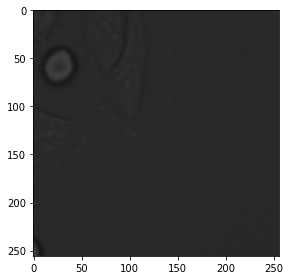

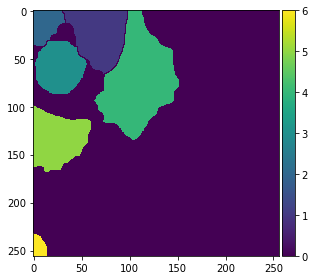

1.0

In [10]:
io.imshow(X_test[1,:,:,0])
plt.show()
io.imshow(y_test[1,:,:,0])
plt.show()
syotil.csi(y_test[1,:,:,0], masks[1,:,:,0])

In [11]:
# read CD3 data

img=io.imread("images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png")
print(img.shape)
X_cd3=img[:,:,2]
#io.imshow(im)
#plt.show()
X_cd3=np.expand_dims(X_cd3, -1) 
X_cd3=np.expand_dims(X_cd3, 0) 

y_cd3=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(y_cd3.shape)
#io.imshow(mask_true)
#plt.show()
y_cd3=np.expand_dims(y_cd3, -1) 
y_cd3=np.expand_dims(y_cd3, 0) 

batch_size_cd3 = 1

print(X_cd3.shape)
print(y_cd3.shape)

train_cd3 = datagen.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_cd3 = datagen_val.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

(256, 256, 3)
(256, 256)
(1, 256, 256, 1)
(1, 256, 256, 1)


In [12]:
# make predictions on CD3 data
start = default_timer()
test_images = prediction_model.predict(X_cd3)
watershed_time = default_timer() - start

pred_cd3 = deep_watershed(
    test_images,
    min_distance=0,
    detection_threshold=0.001,
    distance_threshold=0.0,
    exclude_border=False,
    small_objects_threshold=0)

(1, 256, 256, 1) (1, 256, 256, 1)


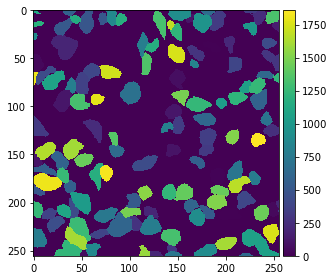

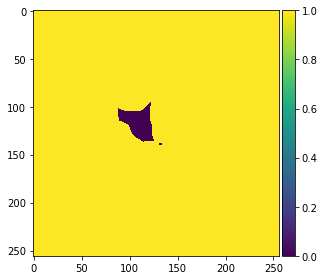

0.0

In [13]:
print(y_cd3.shape, pred_cd3.shape)
io.imshow(y_cd3[0,:,:,0])
plt.show()
io.imshow(pred_cd3[0,:,:,0])
plt.show()
syotil.csi(y_cd3[0,:,:,0], pred_cd3[0,:,:,0])
# the cyto_fluo training data cells are bigger than CD3 cells

In [14]:
# fit again with K data

loss_history = model.fit(
    train_cd3,
    steps_per_epoch=train_cd3.y.shape[0] // batch_size_cd3,
    epochs=100,
    validation_data=val_cd3,
    validation_steps=val_cd3.y.shape[0] // batch_size_cd3,
    callbacks=train_callbacks)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1137 - semantic_0_loss: 0.0424 - semantic_1_loss: 0.0560 - semantic_2_loss: 0.0153
Epoch 00001: val_loss did not improve from 0.00474
1/1 [==============================] - 2s 2s/step - loss: 0.1137 - semantic_0_loss: 0.0424 - semantic_1_loss: 0.0560 - semantic_2_loss: 0.0153 - val_loss: 0.1018 - val_semantic_0_loss: 0.0361 - val_semantic_1_loss: 0.0532 - val_semantic_2_loss: 0.0126 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0979 - semantic_0_loss: 0.0356 - semantic_1_loss: 0.0487 - semantic_2_loss: 0.0136
Epoch 00002: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 269ms/step - loss: 0.0979 - semantic_0_loss: 0.0356 - semantic_1_loss: 0.0487 - semantic_2_loss: 0.0136 - val_loss: 0.1012 - val_semantic_0_loss: 0.0359 - val_semantic_1_loss: 0.0528 - val_semantic_2_loss: 0.0125 - lr: 9.9000e-05
Epoch 3/100
1/1 [==============================] - ET

1/1 [==============================] - ETA: 0s - loss: 0.0658 - semantic_0_loss: 0.0244 - semantic_1_loss: 0.0362 - semantic_2_loss: 0.0053
Epoch 00018: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 264ms/step - loss: 0.0658 - semantic_0_loss: 0.0244 - semantic_1_loss: 0.0362 - semantic_2_loss: 0.0053 - val_loss: 0.0784 - val_semantic_0_loss: 0.0291 - val_semantic_1_loss: 0.0424 - val_semantic_2_loss: 0.0068 - lr: 8.4294e-05
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.0545 - semantic_0_loss: 0.0216 - semantic_1_loss: 0.0280 - semantic_2_loss: 0.0049
Epoch 00019: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 273ms/step - loss: 0.0545 - semantic_0_loss: 0.0216 - semantic_1_loss: 0.0280 - semantic_2_loss: 0.0049 - val_loss: 0.0766 - val_semantic_0_loss: 0.0287 - val_semantic_1_loss: 0.0414 - val_semantic_2_loss: 0.0065 - lr: 8.3451e-05
Epoch 20/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0385 - semantic_0_loss: 0.0159 - semantic_1_loss: 0.0198 - semantic_2_loss: 0.0027
Epoch 00035: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 265ms/step - loss: 0.0385 - semantic_0_loss: 0.0159 - semantic_1_loss: 0.0198 - semantic_2_loss: 0.0027 - val_loss: 0.0588 - val_semantic_0_loss: 0.0241 - val_semantic_1_loss: 0.0304 - val_semantic_2_loss: 0.0043 - lr: 7.1055e-05
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0582 - semantic_0_loss: 0.0239 - semantic_1_loss: 0.0306 - semantic_2_loss: 0.0037
Epoch 00036: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 281ms/step - loss: 0.0582 - semantic_0_loss: 0.0239 - semantic_1_loss: 0.0306 - semantic_2_loss: 0.0037 - val_loss: 0.0581 - val_semantic_0_loss: 0.0239 - val_semantic_1_loss: 0.0299 - val_semantic_2_loss: 0.0042 - lr: 7.0345e-05
Epoch 37/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0308 - semantic_0_loss: 0.0127 - semantic_1_loss: 0.0157 - semantic_2_loss: 0.0024
Epoch 00052: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 268ms/step - loss: 0.0308 - semantic_0_loss: 0.0127 - semantic_1_loss: 0.0157 - semantic_2_loss: 0.0024 - val_loss: 0.0496 - val_semantic_0_loss: 0.0211 - val_semantic_1_loss: 0.0250 - val_semantic_2_loss: 0.0035 - lr: 5.9896e-05
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0443 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0235 - semantic_2_loss: 0.0030
Epoch 00053: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 268ms/step - loss: 0.0443 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0235 - semantic_2_loss: 0.0030 - val_loss: 0.0493 - val_semantic_0_loss: 0.0209 - val_semantic_1_loss: 0.0249 - val_semantic_2_loss: 0.0034 - lr: 5.9297e-05
Epoch 54/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0448 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0243 - semantic_2_loss: 0.0028
Epoch 00069: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 267ms/step - loss: 0.0448 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0243 - semantic_2_loss: 0.0028 - val_loss: 0.0446 - val_semantic_0_loss: 0.0188 - val_semantic_1_loss: 0.0229 - val_semantic_2_loss: 0.0030 - lr: 5.0489e-05
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0498 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0270 - semantic_2_loss: 0.0032
Epoch 00070: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 271ms/step - loss: 0.0498 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0270 - semantic_2_loss: 0.0032 - val_loss: 0.0445 - val_semantic_0_loss: 0.0187 - val_semantic_1_loss: 0.0228 - val_semantic_2_loss: 0.0030 - lr: 4.9984e-05
Epoch 71/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0297 - semantic_0_loss: 0.0126 - semantic_1_loss: 0.0148 - semantic_2_loss: 0.0023
Epoch 00086: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 279ms/step - loss: 0.0297 - semantic_0_loss: 0.0126 - semantic_1_loss: 0.0148 - semantic_2_loss: 0.0023 - val_loss: 0.0425 - val_semantic_0_loss: 0.0181 - val_semantic_1_loss: 0.0217 - val_semantic_2_loss: 0.0028 - lr: 4.2559e-05
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0498 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0269 - semantic_2_loss: 0.0032
Epoch 00087: val_loss did not improve from 0.00474
1/1 [==============================] - 0s 267ms/step - loss: 0.0498 - semantic_0_loss: 0.0197 - semantic_1_loss: 0.0269 - semantic_2_loss: 0.0032 - val_loss: 0.0424 - val_semantic_0_loss: 0.0181 - val_semantic_1_loss: 0.0216 - val_semantic_2_loss: 0.0027 - lr: 4.2133e-05
Epoch 88/100
1/1 [==============================] - ETA: 0s -